#Project Objective

- Perform Exploratory Data Analysis on our data.
- To predict the sentiment of a given financial news headline and determine if it is Positive, Neutral or Negative.

**Import the libraries**

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import nltk
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC

import tensorflow as tf

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('all-data.csv', names=['Label', 'Text'], encoding='latin-1')

In [3]:
data.head()

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4846 non-null   object
 1   Text    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [5]:
data.isnull().sum()

Label    0
Text     0
dtype: int64

In [6]:
data.shape

(4846, 2)

In [7]:
data = data.drop_duplicates()
data.shape

(4840, 2)

In [8]:
data['Label'].value_counts()

Label
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64

<Axes: xlabel='Label'>

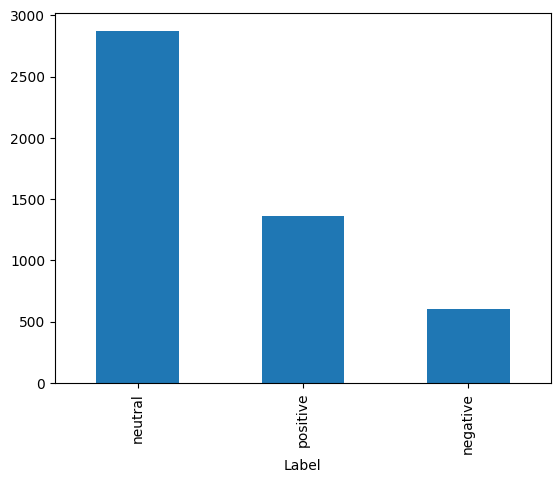

In [9]:
data['Label'].value_counts().plot(kind='bar')

Text Preprocessing

In [12]:
def preprocess(sentence):
  """ INPUT : Sentence
  OUTPUT : Sentence
  Pre processing step for a pandas dataset """
  #sentence = sentence.decode("utf-8-sig") #decoding function
  sentence=str(sentence) #convert to string datatype
  sentence = sentence.lower() #lower case the text
  sentence=sentence.replace('{html}',"") #remove html
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext) #remove urls
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

  return filtered_words

In [13]:
data['Text']=data['Text'].map(lambda s:preprocess(s))

In [14]:
lemmatizer = WordNetLemmatizer() #initialize lemmatizer

#function to lemmatize tokens
def lemmatize_tokens(tokens):
  #convert POS tag to WordNet format
  def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

  # lemmatize tokens
  lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  #return lemmatized tokens as a list
  return lemmas


In [15]:
#apply the lemmatization function to the text column
data['Text']=data['Text'].apply(lemmatize_tokens)

In [16]:
data.head()

,Label,Text
0,neutral,"[accord, gran, company, plan, move, production..."
1,neutral,"[technopolis, plan, develop, stage, area, less..."
2,negative,"[international, electronic, industry, company,..."
3,positive,"[new, production, plant, company, would, incre..."
4,positive,"[accord, company, update, strategy, year, basw..."


In [17]:
data['Text'] = data['Text'].apply(lambda x: " ".join(x))

In [18]:
data.head()

,Label,Text
0,neutral,accord gran company plan move production russi...
1,neutral,technopolis plan develop stage area less squar...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,accord company update strategy year basware ta...


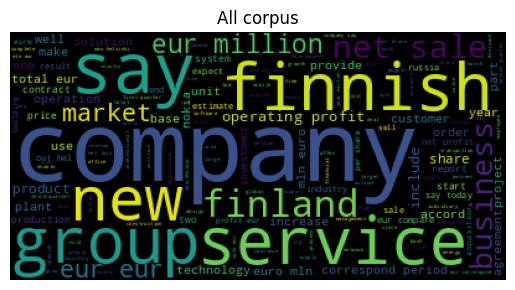

<Figure size 640x480 with 0 Axes>

In [19]:
def plot_word_cloud(data,text='Text',label=None,save=True):
  """ Inputs : Dataset, text colums,labels column
  Output : Word cloud for all the corpus and for each label"""
  word_cloud_data = " ".join([post for post in data['Text'] ])
  word_cloud_data = WordCloud(stopwords=STOPWORDS).generate(word_cloud_data)
  plt.figure()
  plt.imshow(word_cloud_data)
  plt.title('All corpus')
  plt.axis("off")
  plt.show()
  if save:
    plt.savefig('wordcloud.png', dpi=300)
  if label !=None:
    labels=data['Label'].unique()
    for i in range(len(labels)):
          word_cloud_data = " ".join([post for (post,label) in zip(data['Text'],data['Label']) if label==labels[i]])
          word_cloud_data = WordCloud(stopwords=STOPWORDS).generate(word_cloud_data)
          plt.figure(i)
          plt.imshow(word_cloud_data)
          plt.title('{}'.format(labels[i]))
          plt.axis("off")
plot_word_cloud(data,text='Text')

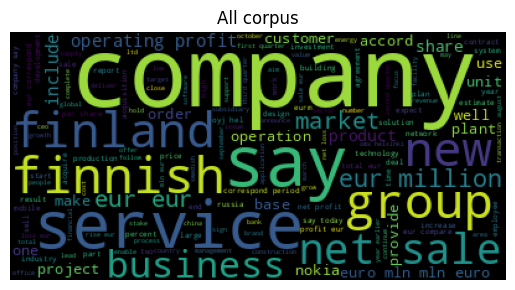

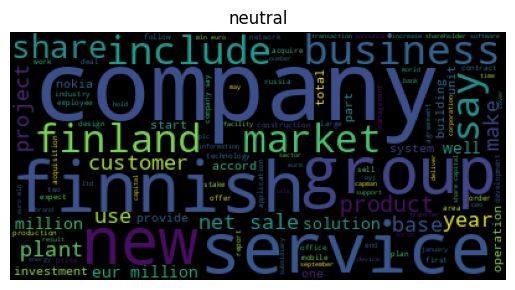

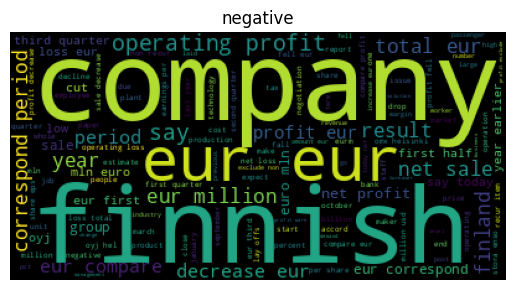

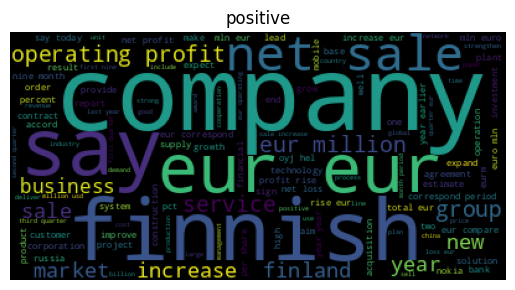

In [20]:
plot_word_cloud(data,'Text','sentiment',False)

In [21]:
def get_sequences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)

    max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    print("Maximum sequence length:", max_seq_length)

    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences

In [22]:
def preprocess_inputs(df):
    df = df.copy()

    sequences = get_sequences(df['Text'])

    label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }

    y = df['Label'].replace(label_mapping)

    train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, y, train_size=0.7, shuffle=True, random_state=1)

    return train_sequences, test_sequences, y_train, y_test

In [23]:
train_sequences, test_sequences, y_train, y_test = preprocess_inputs(data)

Vocab length: 7286
Maximum sequence length: 36


In [24]:
train_sequences

array([[   4, 1029, 1004, ...,    0,    0,    0],
       [ 435,  118,  719, ...,    0,    0,    0],
       [ 191,   47,    8, ...,    0,    0,    0],
       ...,
       [ 213,  163, 2885, ...,    0,    0,    0],
       [6690,  441, 1960, ...,    0,    0,    0],
       [   9,  329,  459, ...,    0,    0,    0]], dtype=int32)

In [25]:
y_train

2351    1
1071    1
716     2
4398    0
4830    0
       ..
2899    1
2767    1
905     2
3986    1
235     2
Name: Label, Length: 3388, dtype: int64

Training

In [61]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(
    input_dim=10123,
    output_dim=128,
    input_length=train_sequences.shape[1]
)(inputs)
x = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh', recurrent_dropout=0.4)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 36)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 36, 128)           1295744   
                                                                 
 gru_3 (GRU)                 (None, 36, 256)           296448    
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27651     
                                                                 
Total params: 1619843 (6.18 MB)
Trainable params: 1619843 (6.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 2.6081601231716705, 1: 0.5615779877341289, 2: 1.1963276836158192}


In [55]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_sequences,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
85/85 [==============================] - 18s 172ms/step - loss: 0.9871 - accuracy: 0.5026 - val_loss: 0.9528 - val_accuracy: 0.5531
Epoch 2/100
85/85 [==============================] - 13s 155ms/step - loss: 0.5088 - accuracy: 0.7996 - val_loss: 0.7810 - val_accuracy: 0.6903
Epoch 3/100
85/85 [==============================] - 8s 97ms/step - loss: 0.2354 - accuracy: 0.9148 - val_loss: 0.9533 - val_accuracy: 0.6726
Epoch 4/100
85/85 [==============================] - 11s 133ms/step - loss: 0.1334 - accuracy: 0.9539 - val_loss: 1.1910 - val_accuracy: 0.6711
Epoch 5/100
85/85 [==============================] - 10s 116ms/step - loss: 0.1043 - accuracy: 0.9664 - val_loss: 1.4740 - val_accuracy: 0.6593


Result

In [56]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

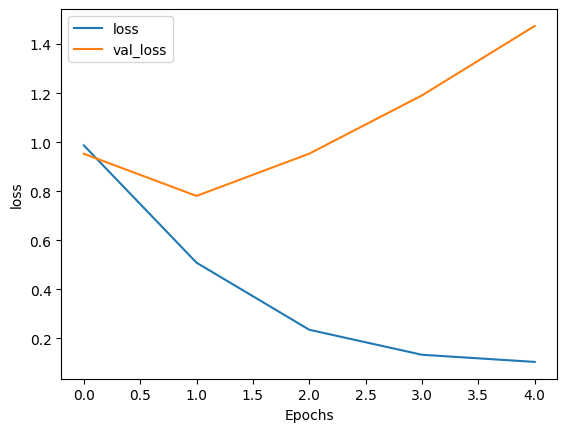

In [57]:
plot_graphs(history, 'loss')

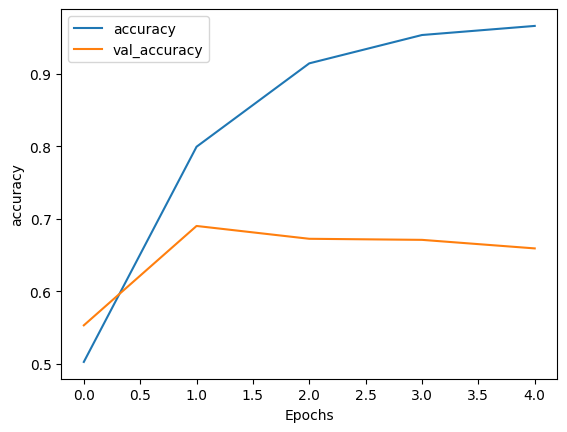

In [58]:
plot_graphs(history, 'accuracy')

In [59]:
results = model.evaluate(test_sequences, y_test, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.70778
Test Accuracy: 71.21%


The model is highly overfitting and that is why it performed badly on the test(new) data. Our next task is to fix it and make it more generalized and can be able perform well on the validation data.

In [67]:
#!pip install keras_tuner

In [68]:
# import keras_tuner as kt
# import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation


# def model_builder(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh'))
#     model.add(Dense(3, activation='softmax'))

#     model.compile(
#         optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001])),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# tuner = kt.Hyperband(
#     model_builder,
#     objective='val_accuracy',
#     max_epochs=10,
# )

# tuner.search(train_sequences, y_train, epochs=50, validation_split=0.2, class_weight=class_weights_dict)
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]